In [213]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats

cms = pd.read_excel(r"C:\Users\utilisateur\Documents\brief_3\Challenge_Data\web.xlsx")
erp = pd.read_excel(r"C:\Users\utilisateur\Documents\brief_3\Challenge_Data\erp.xlsx")
liaison = pd.read_excel(r"C:\Users\utilisateur\Documents\brief_3\Challenge_Data\liaison.xlsx")

sku = cms.iloc[:,0]
id_product = erp.iloc[:,0]

# print(sku.value_counts)
# print(len(sku))

# print(id_product.value_counts)
# print(len(id_product))
# On a bien autant de valeur que de ligne donc sku identifie bien la table cms.


# on joint la table erp et liaison
df = pd.merge(erp,liaison, on='product_id', how = "inner")
# On supprime les données null des identifiant id_web
df = df[~df['id_web'].isnull()]

# On joint la table cms avec notre dernière liaison
data = pd.merge(df, cms, left_on="id_web", right_on="sku", how = "inner")

# on cherche les index qui correspondent à "attachment" car elle correspondent 
# à un fichier image du produit, qui n'est pas un produit en vente et qui nous 
# alourdie la table et nous fausse le calcul du chiffre d'affaire.
index = data[data.post_type == "attachment"].index.tolist()
# On supprime ces lignes
data = data.drop(index)
# On reset les index afin qu'ils suivent (pour éviter les sauts d'index du type 0 2 4 6 8...)
data.reset_index(inplace = True)

print(df)
print(data)

     product_id  onsale_web  price  stock_quantity stock_status   id_web
0          3847           1   24.2               0   outofstock    15298
1          3849           1   34.3               0   outofstock    15296
2          3850           1   20.8               0   outofstock    15300
3          4032           1   14.1               0   outofstock    19814
4          4039           1   46.0               0   outofstock    19815
..          ...         ...    ...             ...          ...      ...
792        7023           1   27.5              15      instock    15891
793        7025           1   69.0               2      instock    15887
822        7247           1   54.8              23      instock  13127-1
823        7329           0   26.5              14      instock  14680-1
824        7338           1   16.3              45      instock    16230

[734 rows x 6 columns]
     index  product_id  onsale_web  price  stock_quantity stock_status  \
0        0        3847    

C:\Users\utilisateur\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
C:\Users\utilisateur\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
C:\Users\utilisateur\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [186]:
# print(data.columns.tolist())

# pour calculer le chiffre d'affaire par produit il nous suffit de multiplier
# le prix d'un produit à son nombre de vente. Et il suffit de faire la somme
# pour obtenir le chiffre d'affaire total
res = data.loc[:,'price'] * data.loc[:,'total_sales']
data_res = pd.DataFrame({"Chiffre d'affaire d'une bouteille": res , "Nom de la bouteille":data.loc[:,'post_name']})

print(data_res)
print("Et voici le chiffre d'affaire total :",sum(res))

     Chiffre d'affaire d'une bouteille  \
0                                145.2   
1                                  0.0   
2                                  0.0   
3                                 42.3   
4                                  0.0   
..                                 ...   
709                               42.0   
710                                0.0   
711                                0.0   
712                                0.0   
713                                0.0   

                                   Nom de la bouteille  
0          pierre-jean-villa-saint-joseph-preface-2018  
1            pierre-jean-villa-saint-joseph-tilde-2017  
2    pierre-jean-villa-croze-hermitage-accroche-coe...  
3                    pierre-jean-villa-igp-gamine-2018  
4            pierre-jean-villa-cote-rotie-carmina-2017  
..                                                 ...  
709                    mouthes-le-bihan-aime-chai-2015  
710         camin-larredya-jurancon-sec

In [215]:
prix = data.loc[:,'price']
# Le z-score correspond au calcul : Z = (x - mean) / sigma
# mean étant la moyenne, sigma l'écart-type et x une variable

length = len(prix)

# On calcul la moyenne des prix des produits
mean = sum(prix) / length

# On calcul l'écart-type des prix des produits
square = 0
for i in range (length):
    square += (mean - prix[i])**2
sigma = (square / length) ** 0.5

print(mean, sigma)

# Il nous rest plus qu'à appliqué notre équation Z = (x - mean) / sigma
z_score = (prix - mean)/sigma
print(z_score)

# On vérifie notre résultat grâce à la fonction zcore de scipy.stats
z_verif = stats.zscore(prix)
print(z_verif)

data = data.assign(z_score = z_score)

32.49313725490197 27.791042941002935
     index  product_id  onsale_web  price  stock_quantity stock_status  \
0        0        3847           1   24.2               0   outofstock   
1        2        3849           1   34.3               0   outofstock   
2        4        3850           1   20.8               0   outofstock   
3        6        4032           1   14.1               0   outofstock   
4        8        4039           1   46.0               0   outofstock   
..     ...         ...         ...    ...             ...          ...   
709   1418        6930           1    8.4              83      instock   
710   1420        7023           1   27.5              15      instock   
711   1422        7025           1   69.0               2      instock   
712   1424        7247           1   54.8              23      instock   
713   1426        7338           1   16.3              45      instock   

      id_web      sku  virtual  downloadable  ...       post_modified  \
0

In [226]:
# Pour ce qui est de l'approche statistique, il est spécifié que le Z-score doit
# Être en dessous de 2 écart-type de différence, c'est-à-dire que l'on va supprimer
# Les valeurs qui ont un Z-score inférieur à -2 et supérieur à 2.

data_prix = pd.DataFrame({"Prix_bouteille": prix , "Z_score":z_score, "Nom_bouteille":data.post_name})

data_prix_res = data_prix[(data_prix.Z_score < 2) & (data_prix.Z_score > -2)]
data_aberrant = data_prix[(data_prix.Z_score > 2)]

print(data_prix_res.head(n=3))
print("\nNous avons au final",(len(data_prix)-len(data_prix_res)) ,'lignes qui avait plus de 2 écart-type de différence avec la moyenne')
print("\nVoici les valeurs abérantes trouver grâce au z score :\n", data_aberrant.head())

# On se rend compte que les données aberrante sont toute des bouteilles à plus de 88 euros.
# Il suffit au commerçant de regarder si ces bouteilles sont de base cher ou non
# Si elle ne le sont pas, alors il y a une erreure.

   Prix_bouteille   Z_score                                      Nom_bouteille
0            24.2 -0.298410        pierre-jean-villa-saint-joseph-preface-2018
1            34.3  0.065016          pierre-jean-villa-saint-joseph-tilde-2017
2            20.8 -0.420752  pierre-jean-villa-croze-hermitage-accroche-coe...

Nous avons au final 30 lignes qui avait plus de 2 écart-type de différence avec la moyenne

Voici les valeurs abérantes trouver grâce au z score :
      Prix_bouteille   Z_score  \
63            100.0  2.429087   
65             88.4  2.011686   
199           225.0  6.926939   
201           126.5  3.382632   
218           176.0  5.163781   

                                         Nom_bouteille  
63   zind-humbrecht-riesling-gc-rangen-thann-clos-s...  
65   zind-humbrecht-pinot-gris-grand-cru-rangen-de-...  
199     champagne-egly-ouriet-grand-cru-millesime-2008  
201  champagne-egly-ouriet-grand-cru-brut-blanc-de-...  
218                               cognac-frapin-vip

C:\Users\utilisateur\AppData\Local\Temp\ipykernel_14424\690440283.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_prix.Categorie[i] = int(0)
C:\Users\utilisateur\AppData\Local\Temp\ipykernel_14424\690440283.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_prix.Categorie[i] = int(1)


   Prix_bouteille   Z_score  \
0            24.2 -0.298410   
1            34.3  0.065016   
2            20.8 -0.420752   
3            14.1 -0.661837   
4            46.0  0.486015   

                                       Nom_bouteille  Categorie  
0        pierre-jean-villa-saint-joseph-preface-2018        0.0  
1          pierre-jean-villa-saint-joseph-tilde-2017        0.0  
2  pierre-jean-villa-croze-hermitage-accroche-coe...        0.0  
3                  pierre-jean-villa-igp-gamine-2018        0.0  
4          pierre-jean-villa-cote-rotie-carmina-2017        0.0  
     Prix_bouteille   Z_score  \
63            100.0  2.429087   
65             88.4  2.011686   
199           225.0  6.926939   
201           126.5  3.382632   
218           176.0  5.163781   

                                         Nom_bouteille  Categorie  
63   zind-humbrecht-riesling-gc-rangen-thann-clos-s...        1.0  
65   zind-humbrecht-pinot-gris-grand-cru-rangen-de-...        1.0  
199     champa

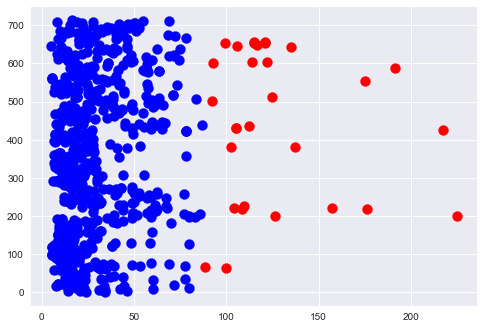

In [227]:
# Nous allons maitenant créer un graphique qui affichera les valeurs 
# ayant un Z_score supérieur à 2 et infèrieur à -2

# Pour cela nous allons créer une colonne catégorie qui prendra la valeure de 
# 1 si le z_score et supérieur à 2 ou inférieur à -2 et 0 sinon.

# Création de la colonne
data_prix['Categorie'] = np.nan

#Boucle for qui va changer les valeurs de Catégorie par 1 ou 0 selon les conditions
for i in range(len(data_prix.Z_score)):
    if data_prix.Z_score[i] > 2 or data_prix.Z_score[i] < -2:
        data_prix.Categorie[i] = int(1)
    else:
        data_prix.Categorie[i] = int(0)

# ligne qui vérifie si les valeurs de catégorie on bien changé
# print(data_prix.head())
# print(data_prix[(data_prix.Z_score > 2)].head())

# On fini par afficher les valeurs abérantes en rouge et les autres en bleu
plt.scatter(data_prix.Prix_bouteille[(data_prix.Categorie == 0)], data_prix.index[(data_prix.Categorie == 0)],s=100, c='blue')
plt.scatter(data_prix.Prix_bouteille[(data_prix.Categorie == 1)], data_prix.index[(data_prix.Categorie == 1)],s=100, c='red')

# On peut ainsi identifier le nom des bouteilles qui sont "anormal" et se
# rendre compte si le prix qui leur est attribuer et correct ou non.
index = data_prix[data_prix.Categorie == 1].index.tolist()
print("\n", data.iloc[index,[3,25]])

       Prix_bouteille
count      714.000000
mean        32.493137
std         27.810525
min          5.200000
25%         14.100000
50%         23.550000
75%         42.175000
max        225.000000


C:\Users\utilisateur\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


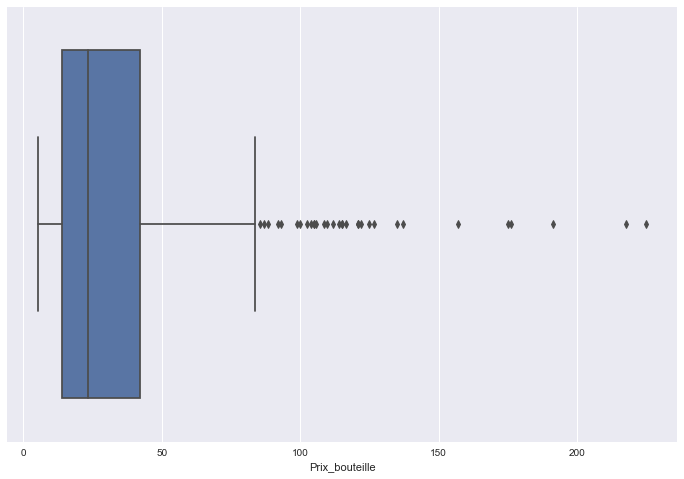

In [228]:
plt.style.use('seaborn')

prix = pd.DataFrame({"Prix_bouteille":data.loc[:,'price']})

print(prix.describe())

plt.figure(figsize=(12,8))
sns.boxplot(prix['Prix_bouteille'])
plt.show()

# Nous pouvons observer la présence de valeurs aberrantes. Qui se situe après
# l'extrémité supérieur. Mais aucune avant l'extrémité inférieur

In [235]:
# Nous allons maintenant découvrir et filtrer ces valeurs abérantes
# On commence par déterminé les quantiles Q1 -> 25% des données, Q3 -> 75% 
# des données et IQR -> espace interquantile
Q3 = np.quantile(prix["Prix_bouteille"], 0.75)
Q1 = np.quantile(prix["Prix_bouteille"], 0.25)
IQR = Q3 - Q1

# On va maintenant calculer les extrémités du boxplot
# A savoir que si notre extremité superieur est plus grande que notre donnée maximal
# alors notre donnée maximal sera notre extrémité supérieur. Idem pour notre extrémité
# inférieur, si elle est plus petite que la donnée la plus petite alors la donnée la 
# plus petite sera notre extremité inférieur

lower_range = Q1 - 1.5 * IQR
upper_range = Q3 + 1.5 * IQR
print("L'éxtrémité la plus basse est :",lower_range)
print("L'éxtrémité la plus haute est :",upper_range)

if lower_range < min(prix['Prix_bouteille']):
    lower_range = min(prix['Prix_bouteille'])
    print("L'éxtrémité basse étant plus petite que la donnée minimal on va la changé et utilisé la donnée la plus basse :", lower_range)

if upper_range > max(prix['Prix_bouteille']):
    upper_range = max(prix['Prix_bouteille'])
    print("L'éxtrémité haute étant plus grande que la donnée maximal on va la changé et utilisé la donnée la plus haute", upper_range)

# On va maintenant créer une db avec les valeures aberrantes ainsi que
# le prix des bouteilles et leurs noms 

data_aberante_2 = pd.DataFrame({"Prix_Bouteille":data.price, "Nom_Bouteille":data.post_name})
data_aberante_2 = data_aberante_2[(data_aberante_2.Prix_Bouteille > upper_range) | (data_aberante_2.Prix_Bouteille < lower_range)]

print("Nous avons donc",len(data_aberante_2) ,"données abérante concernant les prix des bouteilles")
print(data_aberante_2)

# On obtient un résultat assez proche et similaire qu'avec le z_score
# La conclusion ici est la même que pour z score.

L'éxtrémité la plus basse est : -28.012500000000003
L'éxtrémité la plus haute est : 84.28750000000001
L'éxtrémité basse étant plus petite que la donnée minimal on va la changé et utilisé la donnée la plus basse : 5.2
Nous avons donc 32 données abérante concernant les prix des bouteilles
     Prix_Bouteille                                      Nom_Bouteille
63            100.0  zind-humbrecht-riesling-gc-rangen-thann-clos-s...
65             88.4  zind-humbrecht-pinot-gris-grand-cru-rangen-de-...
199           225.0     champagne-egly-ouriet-grand-cru-millesime-2008
201           126.5  champagne-egly-ouriet-grand-cru-brut-blanc-de-...
205            85.6  champagne-larmandier-bernier-grand-cru-vieille...
218           176.0                               cognac-frapin-vip-xo
219           108.5                         cognac-frapin-fontpinot-xo
221           157.0     cognac-frapin-chateau-de-fontpinot-1989-20-ans
222           104.0                          cognac-frapin-cigar-blend
22